# Univariate Diagnostics

In [ ]:
# Use magic commands (%)

# When modifying libraries, no need to restart the kernel
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import src.copa.util_functions as u

In [ ]:
u.setPandasOptions()

In [ ]:
fsu = pd.read_csv("data/fsu_clean.csv") 

In [ ]:
fsu = u.additionalCleanup(fsu)

# Flights
* Every row is a different flight
* Flight by hour, day, week, month

## General Strategy
* Collect the columns of interest into a Dataframe
* Work with that dataframe
* Much faster since less data

In [ ]:
data = fsu['FLT_NUM']

In [ ]:
fsu.hist(bins=50, figsize=(20,10));
plt.tight_layout()

## Looking at these plots, which look useful and which don't? 
* CANCEL_CD, COUNT_CANCELLATIONS, SCHEDULED_ALL, SCHEDULED_CNT, SCHEDULED_CNT_ALL, have one value, so useless
    * this is the result of filteirng out cancellations
* CAPACITY_Y_CNT has 5 values, and CAPACITY_C_NT has 3. 
* DEP_DELAY_MINUTES has two values: 0 and 10,000, which must be outliers since we know that there are many flights with 5 min delay
    * this must be addressed
* CREW_CNT: has a very large numbgrer with 0 crew? WEIRD. 
* Show the values of some of these plots using fsu.value_counts()

In [ ]:
fsu1 = fsu.drop(labels=['CANCEL_CD','COUNT_CANCELLATIONS','SCHEDULED_ALL','SCHEDULED_CNT','SCHD_CNT_ALL'], axis=1)

In [ ]:
fsu1.columns

In [ ]:
fsu1['CREW_CNT'].value_counts().head(5)

In [ ]:
# The first value was a vaue I used to replace '?'
# Replace by NaN (which counts as a float)
fsu1['DEP_DELAY_MINUTES'].value_counts()[0:5]
# many zeros (I replaced NaN by zeros)
fsu1['CREW_CNT'].value_counts()[0:5]
fsu1['COUNT_DLY_FLTS_D3H'].value_counts()[0:5]

In [ ]:
fsu.nunique()

In [ ]:
fsu.dtypes

In [ ]:
(fsu['TAXI_IN_MINUTES'] == '?').sum()

In [ ]:
(fsu['TAXI_OUT_MINUTES'] == '?').sum()

* Remove the '?'

In [ ]:
fsu1['TAXI_IN_MINUTES'] = fsu1['TAXI_IN_MINUTES'].replace('?',np.NaN).astype(float)
fsu1['TAXI_OUT_MINUTES'] = fsu1['TAXI_OUT_MINUTES'].replace('?',np.NaN).astype(float)

In [ ]:
fsu1['DEP_DELAY_MINUTES'] = fsu1['DEP_DELAY_MINUTES'].replace(9999,np.NaN).astype(float)
fsu1['CREW_CNT'] = fsu1['DEP_DELAY_MINUTES'].replace(0,np.NaN).astype(float)

In [ ]:
fsu1['TAXI_OUT_MINUTES'].dtype

In [ ]:
# 5898 values of -1435. What is special about these records? 
fsu1['TAXI_IN_MINUTES'].astype(float).sort_values().head()

In [ ]:
fsu1['TAXI_IN_MINUTES'].replace(-1435.0, np.NaN, inplace=True)
# These is one record with negative TAXI_IN_MINUTES. Does not seem possible. Operator entry error?
fsu1['TAXI_IN_MINUTES'] < 0
(fsu1['TAXI_OUT_MINUTES'] < 0).sum()  # all values are positive

In [ ]:
fsu1.hist(bins=50, figsize=(20,8));

# Observation: there are two sets of flights
* We learned from Copa that we should only consider FLT_NUM between 0 and 999.
* As seen below, there are 4051 flights not CM. We remove them. 

In [ ]:
fsu1['TAXI_IN_MINUTES'].hist(bins=50)
plt.xlim(35,120)
plt.ylim(0,40)

## Alternative TAXI time computation: ON (wheels touch) - IN (arrive at the gate)

In [ ]:
# IN_DTMZ has some ?, so I could remove all lines with '?'
(fsu1['IN_DTMZ'] == '?').sum()

In [ ]:
(fsu1['ON_DTMZ'] == '?').sum()

* Let us remove 9 rows from fsu1

In [ ]:
fsu1 = fsu1.loc[fsu1['IN_DTMZ'] != '?', :]

In [ ]:
hmin_in = u.series_to_time_components(fsu1['IN_DTMZ'], suffix='_in')
hmin_on = u.series_to_time_components(fsu1['ON_DTMZ'], suffix='_on')
#d_in    = u.series_to_date_components(fsu1['IN'], suffix='_in').loc[:,'d_in'].to_frame('d_in')
#d_on    = u.series_to_date_components(fsu1['ON'], suffix='_on').loc[:,'d_on'].to_frame('d_on')

In [ ]:
# days and months
d_in = fsu['IN'].str[0:2].astype(int)
d_on = fsu['ON'].str[0:2].astype(int)
m_in = fsu['IN'].str[0:2].astype(int)
m_on = fsu['ON'].str[0:2].astype(int)

# Months are always equal
# Days are not equal

In [ ]:
times = pd.concat([d_in,d_on,hmin_in, hmin_on], axis=1)

In [ ]:
hmin_in_bak = hmin_in.copy()
hmin_on_bak = hmin_on.copy()

In [ ]:
hmin_in = hmin_in_bak.copy()
hmin_on = hmin_on_bak.copy()

In [ ]:
hmin = hmin_in.values - hmin_on.values
minutes_days = (d_in - d_on)*24*60 
minutes = hmin[:,0]*60 + hmin[:,1] 
#plt.hist(minutes, bins=50);
#plt.xlim(-50,120)
#plt.ylim(0,50)
fsu1['minutes'] = minutes
fsu1['minutes_d'] = minutes_days
fsu1[fsu1['minutes'] < 0][['IN','ON','minutes','minutes_d']].head(5)

# The reason for the large negative numbers is clear. IN is slightly after midnight, 
# and OUT is slightly before midnight. If the 'hour' is 0, I should add 24

* Remove about 270 records with minutes < -1000 
    * these result from days off by 1 between IN and ON
* There remains one record with minutes == -25, which we ignore

In [ ]:
fsu1.loc[(fsu1['minutes'] < -1000), :] = np.nan

In [ ]:
fsu1['minutes'].hist(bins=50, range=(0,50))
plt.xlim(0, 40)

In [ ]:
fsu1['minutes'].value_counts().sort_index().head(5)

### There are 454 flights with TAXI_IN > 25 min (out of about 50,000)

In [ ]:
vc = fsu1['minutes'].value_counts()
vc[vc.index > 25].sum()

In [ ]:
fsu1['minutes'].value_counts().sort_index().tail(10)

In [ ]:
hmin_in.loc[hmin_in['h_in'] == 0, 'h_in'] = hmin_in['h_in'] + 24

## Repeat for TAXI_IN_MINUTES

In [ ]:
fsu1.columns

* All values are defined
* However, there are very large tails (> 10 hours!)
* What are these outliers? Are they real ?

In [ ]:
fsu1['TAXI_OUT_MINUTES'].hist(bins=50) #, range=(0,60))

There is clearly an outlier. 

In [ ]:
fsu1['TAXI_OUT_MINUTES'].value_counts().sort_index().tail(5)

So we see some Taxi out times of two hours and one of 10 hours. Look at the record. 
* Always check outliers to determine their cause if possible!

In [ ]:
fsu1[fsu1['TAXI_OUT_MINUTES'] > 700]

We tabulate some values: 
* OUT = 2:24  (time)
* OFF: 14:25  (12 hours, almost exactly, later)
* DEP_DELAY_MINUTES: NaN (so not recorded)
* SCH_DEP_DTMZ: 12/11/2019, 2:24
* Actual departure time: not known. 

So the record can either be ignored, or one must investigate a possible IRROP on that day. 

## Interesting observation 
* There are 3 strong peaks. What are they? 
* Let us changte the number of bars to 70, then 60
* Conclusion the peaks were an artifact of the parameters chosen

## Important lessons: play with different parameters
* Consider bar charts versus histograms
* If x values (x) are equally-spaced, bar charts are often more appropriate

In [ ]:
f = plt.figure(figsize=(10,5))
f.add_subplot(1,3,1)
fsu1['TAXI_OUT_MINUTES'].hist(bins=50, range=(0,55))
f.add_subplot(1,3,2)
fsu1['TAXI_OUT_MINUTES'].hist(bins=60, range=(0,58))
f.add_subplot(1,3,3)
fsu1['TAXI_OUT_MINUTES'].hist(bins=70, range=(0,62))

# Another way to draw outlier: the BoxPlot
* Use the Seaborn library
* Notice the outlier at 700
* replot from 0 to 100

In [ ]:
data = fsu1['TAXI_OUT_MINUTES']
sns.boxplot(data, x='TAXI_OUT_MINUTES')

In [ ]:
sns.boxplot(data, x='TAXI_OUT_MINUTES', color='red')
plt.xlim(0,120)

## Observations and description
* The red rectangle contains 50% of the data (1st and 3rd quartile). 
* The thin black line inside the rectangle is the 2nd quartile.
* The two vertical lines represent the last point beyond the 1.5*IQR
* IQR is the Interquartile = (x[3rd Quart] - x[1st Quart])*1.5 

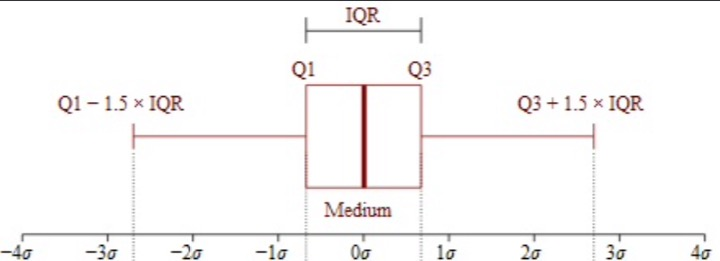

The box plot is often more informative than the histogram
* one can retrieve information about skewness, symmetry, and outliers. 

## Compare the Boxplots of TAXI_IN and TAXI_OUT

In [ ]:
data = fsu1[['TAXI_IN_MINUTES','TAXI_OUT_MINUTES']]
data.boxplot()
plt.ylim(0,150)

## Taxi time (IN vs OUT) : observations
* The median of TAXI_IN is shorter than the median TAXI_OUT
* The middle 50% of TAXI_IN are lower (!!) than the middle 50% of TAXI_OUT
* Both have lots of outliers

In [ ]:
sns.scatterplot(data=data, x='TAXI_IN_MINUTES', y='TAXI_OUT_MINUTES')
plt.ylim(0,100)

## This scatterplot is very interesting
The points are bounded by a region contained by two straight lines and an approximate hyperbola. 
I wonder why. Worth investigating one day?
* What is the second most important variable that correlates TAXI time? 
    * Miles? Block-hours? Delays? 

## Analyze departure and arrival delay, along with TAXI time

In [ ]:
data = fsu1[['TAXI_IN_MINUTES','TAXI_OUT_MINUTES','DEP_DELAY_MINUTES','ARR_DELAY_MINUTES']]  
#data = fsu1[['DEP_DELAY_MINUTES']] 

In [ ]:
# Notice that ARR_DELAY_MINUTES is not plotted
# Also notice that that the box for DEP_DELAY_MINUTES is below zero. 
#    Tehrefore, more than 50% of the flights leave earlier than scheduled!
# Question why are there outliers on the negative side of DEP_DELAY_MINUTES? 
#    What does a 40 min early flight mean?
f = plt.figure(figsize=(10,5))
f.add_subplot(1,2,1)
data.boxplot()
f.add_subplot(1,2,2)
data.boxplot()
plt.ylim(-50,50)
plt.tight_layout()

In [ ]:
# How many outliers are there for departure delays? 
dep_gt_15m = (fsu1['DEP_DELAY_MINUTES'] > 15).sum()
dep_gt_0m = (fsu1['DEP_DELAY_MINUTES'] > 0).sum()

In [ ]:
dep_gt_15m / fsu1.shape[0], dep_gt_0m / fsu1.shape[0]

## Delay statistics
2.8 percent of departures are delayed by more than 0m
0.8 percent of departures are delayed by more than 15m

In [ ]:
fsu1['ARR_DELAY_MINUTES'].value_counts().sort_index(ascending=False)
fsu1['ARR_DELAY_MINUTES'] = fsu1['ARR_DELAY_MINUTES'].astype(float) 

In [ ]:
fsu1['ARR_DELAY_MINUTES'].dtype

In [ ]:
f = plt.figure(figsize=(10,5))
data = fsu1[['TAXI_IN_MINUTES','TAXI_OUT_MINUTES','DEP_DELAY_MINUTES','ARR_DELAY_MINUTES']] 
data.boxplot()
plt.ylim(-50,50)
plt.tight_layout()

## Observation
* Arr_delay_minutes is symmetric for the middle 50% of the observations
* Use of histogram requires more playing with the parameters before getting it right
* First hist with default parameters, then with parameter adjustments

In [ ]:
f = plt.figure(figsize=(10,5))
f.add_subplot(1,2,1)
plt.hist(fsu1['ARR_DELAY_MINUTES'], density=True) 
f.add_subplot(1,2,2)
plt.hist(fsu1['ARR_DELAY_MINUTES'], range=(-50,100), bins=200, density=True);

In [ ]:
sns.histplot(data=data, x='DEP_DELAY_MINUTES')
plt.xlim(-50,100)

In [ ]:
data.columns

In [ ]:
f = plt.figure(figsize=(10,5))
sns.boxplot(data=data)
sns.violinplot(data=data, trim=True, alpha=0.5) 
plt.ylim(-40, 50)

In [ ]:
f = plt.figure(figsize=(10,5))
sns.catplot(data=data.iloc[0:1000], kind='box')
plt.ylim(-40, 50)